# Imports

In [209]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Import functions from preprocessing and training modules
from preprocessing import process_unstructured_data_to_csv, get_labelled_csv, process_all_files
from training import create_model_dataset, load_dataset_with_features

# Import model training libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Preprocess raw data

Fourier transformation of the values from time domain --> frequency domain.

In [211]:
# Get current working directory
cwd = os.getcwd()

# Define data directory
data_dir = os.path.join(cwd, 'sample_data' + '\\' + 'raw_data')

print("Processing data from directory:", data_dir)

Processing data from directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\raw_data


In [212]:
# Delete all previously processed files to avoid conflicts
structured_dir = os.path.join(cwd, 'sample_data' + '\\' + 'structured')
processed_dir = os.path.join(cwd, 'sample_data' + '\\' + 'processed')
labelled_dir = os.path.join(cwd, 'sample_data' + '\\' + 'labelled')
model_data_dir = os.path.join(cwd, 'model_data')

shutil.rmtree(structured_dir, ignore_errors=True)
shutil.rmtree(processed_dir, ignore_errors=True)
shutil.rmtree(labelled_dir, ignore_errors=True)
shutil.rmtree(model_data_dir, ignore_errors=True)

In [213]:
# Load raw data from desired file

file_names = ['shout1.txt', 'shout2.txt', 'shout3.txt', 'drill1.txt', 'drill2.txt', 'drill3.txt']
shout_time_interval = 28 # milliseconds between data points
drill_time_interval = 17 # milliseconds between data points

for file_name in file_names:

    print(f"\nProcessing file: {file_name}")
    
    # Save processed CSV dataframe from the unstructured data file
    if 'shout' in file_name:
        time_interval = shout_time_interval
    elif 'drill' in file_name:
        time_interval = drill_time_interval
    process_unstructured_data_to_csv(data_dir + '\\' + file_name, time_interval)

    # Separate csv further into 'shout' and 'background'
    if 'shout' in file_name:
        get_labelled_csv(data_dir + '\\' + file_name.split('.')[0] + '.csv', type='shout')

    elif 'drill' in file_name:
        get_labelled_csv(data_dir + '\\' + file_name.split('.')[0] + '.csv', type='drill')


Processing file: shout1.txt
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\shout1_structured.csv

Processing file: shout2.txt
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\shout2_structured.csv

Processing file: shout3.txt
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\shout3_structured.csv

Processing file: drill1.txt
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\drill1_structured.csv

Processing file: drill2.txt
Directory: c:\Users\hoxia\Documents\Clo

In [214]:
frame_size = 50  # Number of data points per frame
overlap_percentage = 80 # Percentage of overlap between frames

# For each file, we will create frames and process them with fourier transform, saving results to new CSVs
process_all_files(
    input_base_dir=cwd + '\\' + 'sample_data' + '\\' + 'labelled',  # Contains background/ and shout/ folders with CSVs
    output_base_dir=cwd + '\\' +'sample_data' + '\\' + 'processed',    # Output directory for processed CSVs
    frame_size=frame_size,
    overlap_percent=overlap_percentage
)

Processing background/drill1_2.csv...
Processed 20 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/drill1_4.csv...
Processed 20 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/drill2_2.csv...
Processed 20 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/drill2_4.csv...
Processed 20 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/drill3_2.csv...
Processed 20 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrogr

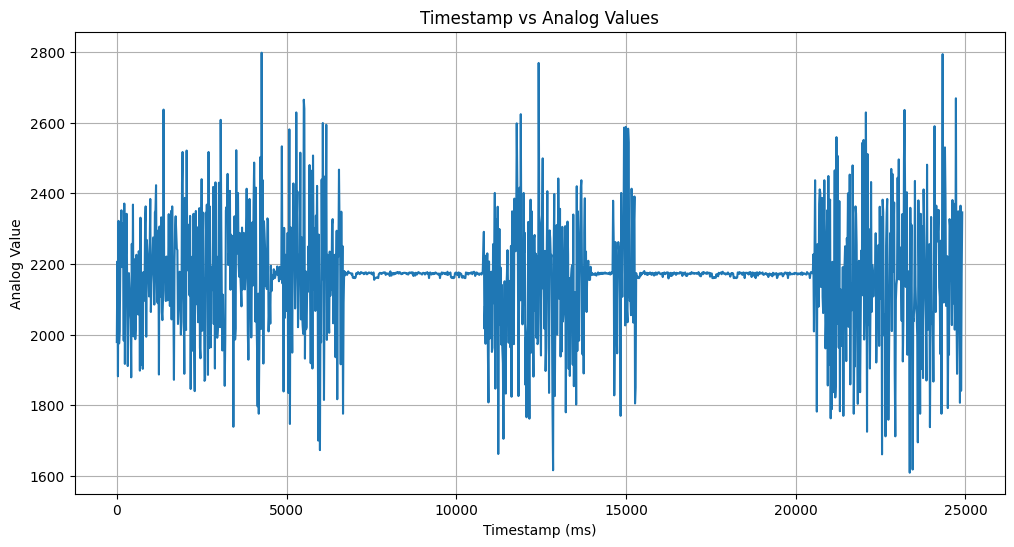

In [215]:
# An example of one set of analog values of raw data
sample_structured_file = cwd + '\\' + 'sample_data' + '\\' + 'structured' + '\\' + 'drill1_structured.csv'

# plot timestamp vs analog values
df = pd.read_csv(sample_structured_file)
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['analog_value'])
plt.title('Timestamp vs Analog Values')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Analog Value')
plt.grid()

# Prepare dataset and train

In [216]:
create_model_dataset(
    freq_domain_dir=cwd + '\\' + 'sample_data' + '\\' + 'processed',
    output_dir=cwd + '\\' + 'model_data'
)


background: 125 train, 27 val, 28 test
shout: 94 train, 20 val, 21 test
drill: 177 train, 38 val, 39 test


In [218]:
X_train, y_train, n_features = load_dataset_with_features(cwd + '\\model_data', 'train')
X_val, y_val, _ = load_dataset_with_features(cwd + '\\model_data', 'validation')
X_test, y_test, _ = load_dataset_with_features(cwd + '\\model_data', 'test')

rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Voting ensemble
voting_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb)],
    voting='soft'
)
voting_model.fit(X_train, y_train)

# Validate model
y_val_pred = voting_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['background', 'shout', 'drill']))

# Test model
y_test_pred = voting_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['background', 'shout', 'drill']))

train set: 396 samples, 13 features (fixed length)
validation set: 85 samples, 13 features (fixed length)
test set: 88 samples, 13 features (fixed length)
Validation Accuracy: 0.6941
Validation Classification Report:
              precision    recall  f1-score   support

  background       0.55      0.22      0.32        27
       shout       0.69      0.90      0.78        20
       drill       0.73      0.92      0.81        38

    accuracy                           0.69        85
   macro avg       0.66      0.68      0.64        85
weighted avg       0.66      0.69      0.65        85

Test Accuracy: 0.6591
Test Classification Report:
              precision    recall  f1-score   support

  background       0.45      0.32      0.38        28
       shout       0.80      0.76      0.78        21
       drill       0.69      0.85      0.76        39

    accuracy                           0.66        88
   macro avg       0.65      0.64      0.64        88
weighted avg       0.64   

Text(0.5, 1.0, 'Confusion Matrix')

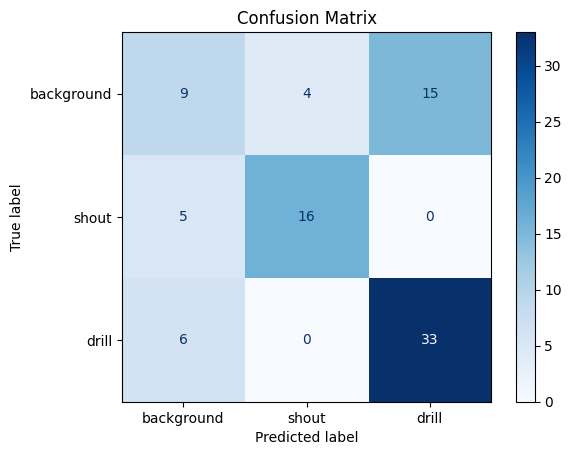

In [220]:
# Confusion Matrix Visualization
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    display_labels=['background', 'shout', 'drill'],
    cmap=plt.cm.Blues,
    normalize=None
)

disp.ax_.set_title("Confusion Matrix")